## Import libraries

In [ ]:
import pandas as pd                                     
import numpy as np                                      
import tensorflow as tf                                 
import os                                               
import cv2                                              
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and preparing training data


In [ ]:
labels = pd.read_csv("/content/drive/MyDrive/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, '/content/drive/MyDrive/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

data = []     
image_size = 32      # image size taken is 32 here. 

for i in range(len(train_data)):
  
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array = cv2.resize(img_array,(image_size,image_size))      # resizing the image array
  data.append(new_img_array) 

## Data Pre-processing
It is necessary to bring all the images to the same shape and size as defined by the VGG-19 model. Also, convert all the labels from categorical to numerical values.

In [ ]:
arr = np.array(data)

In [ ]:
arr

array([[[189, 188, 182, ..., 178, 177, 172],
        [187, 179, 179, ..., 175, 172, 162],
        [185, 181, 184, ..., 168, 157, 149],
        ...,
        [142, 136, 148, ..., 164, 162, 164],
        [140, 150, 161, ..., 169, 164, 164],
        [139, 154, 163, ..., 173, 167, 164]],

       [[170, 175, 172, ..., 190, 193, 194],
        [165, 152, 136, ..., 186, 189, 191],
        [147, 124, 107, ..., 183, 189, 193],
        ...,
        [188, 189, 190, ..., 191, 197, 202],
        [187, 190, 190, ..., 195, 197, 196],
        [186, 190, 190, ..., 200, 201, 197]],

       [[176, 172, 172, ..., 135, 128, 127],
        [168, 165, 165, ...,  91, 114, 111],
        [164, 165, 162, ...,  76,  62,  68],
        ...,
        [131, 143, 148, ..., 115, 112, 103],
        [131, 145, 150, ..., 113, 108,  99],
        [130, 144, 150, ..., 114, 106,  95]],

       ...,

       [[190, 175, 169, ..., 100, 115, 135],
        [177, 161, 147, ...,  83, 103, 101],
        [158, 138, 130, ...,  74,  72,  64

In [ ]:
arr.shape

(9220, 32, 32)

In [ ]:
# reshape into 3 channels for feeding into the model
train_images_3ch = np.stack([arr]*3, axis=-1)
print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))


Train_images.shape: (9220, 32, 32, 3), of uint8


In [ ]:
# normalisation
train_images_scaled = train_images_3ch / 255.

In [ ]:
# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_data[['label']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
train_labels.shape

(9220,)

## Building Model & Hyperparameter tuning


In [ ]:
# Build VGG19 Model

# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE) 

vgg_layers.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True 

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0e6e83a510> True
<keras.layers.convolutional.Conv2D object at 0x7f0e64405cd0> True
<keras.layers.convolutional.Conv2D object at 0x7f0e637b41d0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0e637175d0> True
<keras.layers.convolutional.Conv2D object at 0x7f0e605a87d0> True
<keras.layers.convolutional.Conv2D object at 0x7f0e605a83d0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0e64331f50> True
<keras.layers.convolutional.Conv2D object at 0x7f0e605a8dd0> True
<keras.layers.convolutional.Conv2D object at 0x7f0e605bb2d0> True
<keras.layers.convolutional.Conv2D object at 0x7f0e605530d0> True
<keras.layers.convolutional.Conv2D object at 0x7f0e6054ac50> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0e60557f90> True
<keras.layers.convolutional.Conv2D object at 0x7f0e6055f850> True
<keras.layers.convolutional.Conv2D object at 0x7f0e60564e90> True
<keras.layers.convolutional.Conv2D object at 0x7f0e60557390> True
<keras.l

In [ ]:
# Build CNN model on top of VGG19

# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #single node with ‘sigmoid‘ activation

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [ ]:
EPOCHS = 5

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_scaled, train_labels,
                    batch_size=256,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS, 
                    verbose=1)

## Validate the model


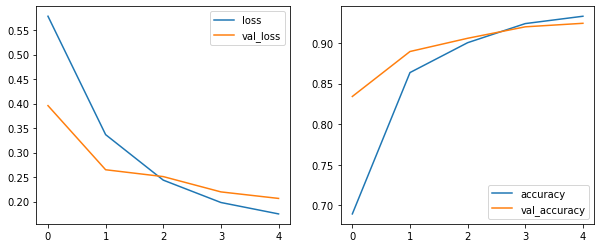

In [ ]:
# Plot Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
# saving the model
save_dir = "/results/"
model_name = 'eye_model.h5'
model.save(model_name)
model_path = save_dir + model_name
print('Saved trained model at %s ' % model_path)

Saved trained model at /results/eye_model.h5 


## Predict The Output For Testing Dataset

## Load Test Set

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/eye_gender_data/Testing_set.csv" )
file_paths_test = [[fname, '/content/drive/MyDrive/eye_gender_data/test/' + fname] for fname in test_data['filename']]
images_test = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])

new_test_data = []
#image_size = 32 

for i in range(len(images_test)):
  
  img_array_test = cv2.imread(images_test['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array_test = cv2.resize(img_array_test, (image_size, image_size))      # resizing the image array
  new_test_data.append(new_img_array_test)

## Data Pre-processing on test_data


In [ ]:
test_arr = np.array(new_test_data)

In [ ]:
test_arr

In [ ]:
test_arr.shape

In [ ]:
# reshape into 3 channels for feeding into the model
test_images_3ch = np.stack([test_arr]*3, axis=-1)
print('\nTest_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))

In [ ]:
# normalisation
test_images_scaled = test_images_3ch / 255.

## Make Prediction on Test Dataset

In [ ]:
test_predictions = model.predict(test_images_scaled)

In [ ]:
images_test['predictprobability'] = test_predictions

In [ ]:
def convert_to_label (row):
  if row['predictprobability'] >=0.5:
    return 'male'
  else:
    return 'female'

images_test['predictlabel'] = images_test.apply(convert_to_label, axis=1)

In [ ]:
images_test.head()

In [ ]:
images_test.tail()

In [ ]:
# Save prediction results locally via colab notebook
images_test.to_csv("images_test.csv", index = False) 

# To download the csv file locally
from google.colab import files        
files.download('images_test.csv')

In [ ]:
res = pd.DataFrame({'label': images_test['predictlabel']}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission.csv')